# 🔵 Notebook 04B: Multi-Algorithm Clustering Comparison

**Objective:** Compare clustering algorithms to validate feature selection

**Algorithms to test:**
1. K-Means (partition-based)
2. DBSCAN (density-based)
3. Hierarchical Agglomerative (tree-based)

**Best features from previous analysis:**
- HighEffect_Only: 7 features (silhouette=0.440)

**Goal:** Validate that results are algorithm-independent

---

## 📦 Step 1: Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.utils import resample
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats
from collections import Counter

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
import warnings
warnings.filterwarnings('ignore')

print("✅ Setup complete")

✅ Setup complete


## 📊 Step 2: Load Data and Best Features

In [15]:
df = pd.read_csv('C:\\Users\\yaros\\Desktop\\python\\faidm\\individual_project\\diabetes-classification-ml\\data_preparation\\dataset_A_clean.csv')
X = df.drop('Diabetes_012', axis=1)
y = df['Diabetes_012']

print(f"Dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Best features from previous analysis (HighEffect_Only strategy)
# Features with effect size > 0.06
best_features = ['BMI', 'HighBP', 'HighChol', 'HeartDiseaseorAttack', 'Stroke', 'CholCheck']

print(f"\n📋 Using 6 best features: {best_features}")

# Select and scale
X_best = X[best_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_best)

print(f"\n✅ Data prepared: {X_scaled.shape}")

Dataset: 229,781 rows × 19 columns

📋 Using 6 best features: ['BMI', 'HighBP', 'HighChol', 'HeartDiseaseorAttack', 'Stroke', 'CholCheck']

✅ Data prepared: (229781, 6)


## 🎲 Step 3: Create Sample for Efficient Computation

In [16]:
print("=" * 60)
print("SAMPLING STRATEGY")
print("=" * 60)

# Two sample sizes:
# 1. Small sample (10k) for silhouette calculation
# 2. Medium sample (50k) for algorithm fitting (faster than 230k)

sample_size_small = 10000  # For metrics
sample_size_medium = min(50000, len(X_scaled))  # For fitting

# Small sample indices
small_indices = resample(range(len(X_scaled)), n_samples=sample_size_small, 
                         random_state=42, replace=False)
X_small = X_scaled[small_indices]
y_small = y.iloc[small_indices]

# Medium sample indices
medium_indices = resample(range(len(X_scaled)), n_samples=sample_size_medium, 
                          random_state=42, replace=False)
X_medium = X_scaled[medium_indices]
y_medium = y.iloc[medium_indices]

print(f"\n📊 Sample sizes:")
print(f"   Full data: {len(X_scaled):,}")
print(f"   Medium (for fitting): {len(X_medium):,} ({len(X_medium)/len(X_scaled)*100:.1f}%)")
print(f"   Small (for metrics): {len(X_small):,} ({len(X_small)/len(X_scaled)*100:.1f}%)")

print(f"\n💡 Strategy:")
print(f"   - Fit algorithms on MEDIUM sample (50k) for speed")
print(f"   - Calculate metrics on SMALL sample (10k) for efficiency")
print(f"   - This balances accuracy with computational feasibility")

SAMPLING STRATEGY

📊 Sample sizes:
   Full data: 229,781
   Medium (for fitting): 50,000 (21.8%)
   Small (for metrics): 10,000 (4.4%)

💡 Strategy:
   - Fit algorithms on MEDIUM sample (50k) for speed
   - Calculate metrics on SMALL sample (10k) for efficiency
   - This balances accuracy with computational feasibility


## 🔍 Step 3.5: Determine Optimal Number of Clusters (K)

**Critical Question:** Why K=3?

**Methods to determine K:**
1. Elbow Method (WCSS curve)
2. Silhouette Score (optimal separation)
3. Domain knowledge (medical risk stratification)

**We'll test K from 2 to 8 and select based on statistical evidence**

In [17]:
print("=" * 60)
print("DETERMINING OPTIMAL NUMBER OF CLUSTERS (K)")
print("=" * 60)

K_range = range(2, 9)
wcss_values = []
silhouette_values = []
davies_bouldin_values = []
calinski_values = []

print("\n🔍 Testing K from 2 to 8...")
print("-" * 60)

for k in K_range:
    # Fit on medium sample
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_medium)
    
    # Predict on small sample for metrics
    labels_small = kmeans.predict(X_small)
    
    # Calculate metrics
    wcss = kmeans.inertia_
    silhouette = silhouette_score(X_small, labels_small)
    davies_bouldin = davies_bouldin_score(X_small, labels_small)
    calinski = calinski_harabasz_score(X_small, labels_small)
    
    wcss_values.append(wcss)
    silhouette_values.append(silhouette)
    davies_bouldin_values.append(davies_bouldin)
    calinski_values.append(calinski)
    
    print(f"K={k}: WCSS={wcss:,.0f}, Silhouette={silhouette:.3f}, DB={davies_bouldin:.3f}, CH={calinski:.0f}")

print("\n✅ K-range testing complete")

DETERMINING OPTIMAL NUMBER OF CLUSTERS (K)

🔍 Testing K from 2 to 8...
------------------------------------------------------------
K=2: WCSS=239,632, Silhouette=0.300, DB=1.690, CH=2451
K=3: WCSS=191,818, Silhouette=0.333, DB=1.311, CH=2630
K=4: WCSS=142,851, Silhouette=0.380, DB=1.044, CH=3523
K=5: WCSS=120,438, Silhouette=0.404, DB=0.970, CH=3603
K=6: WCSS=84,738, Silhouette=0.479, DB=0.801, CH=4909
K=7: WCSS=67,393, Silhouette=0.569, DB=0.699, CH=5609
K=8: WCSS=55,594, Silhouette=0.592, DB=0.742, CH=6209

✅ K-range testing complete


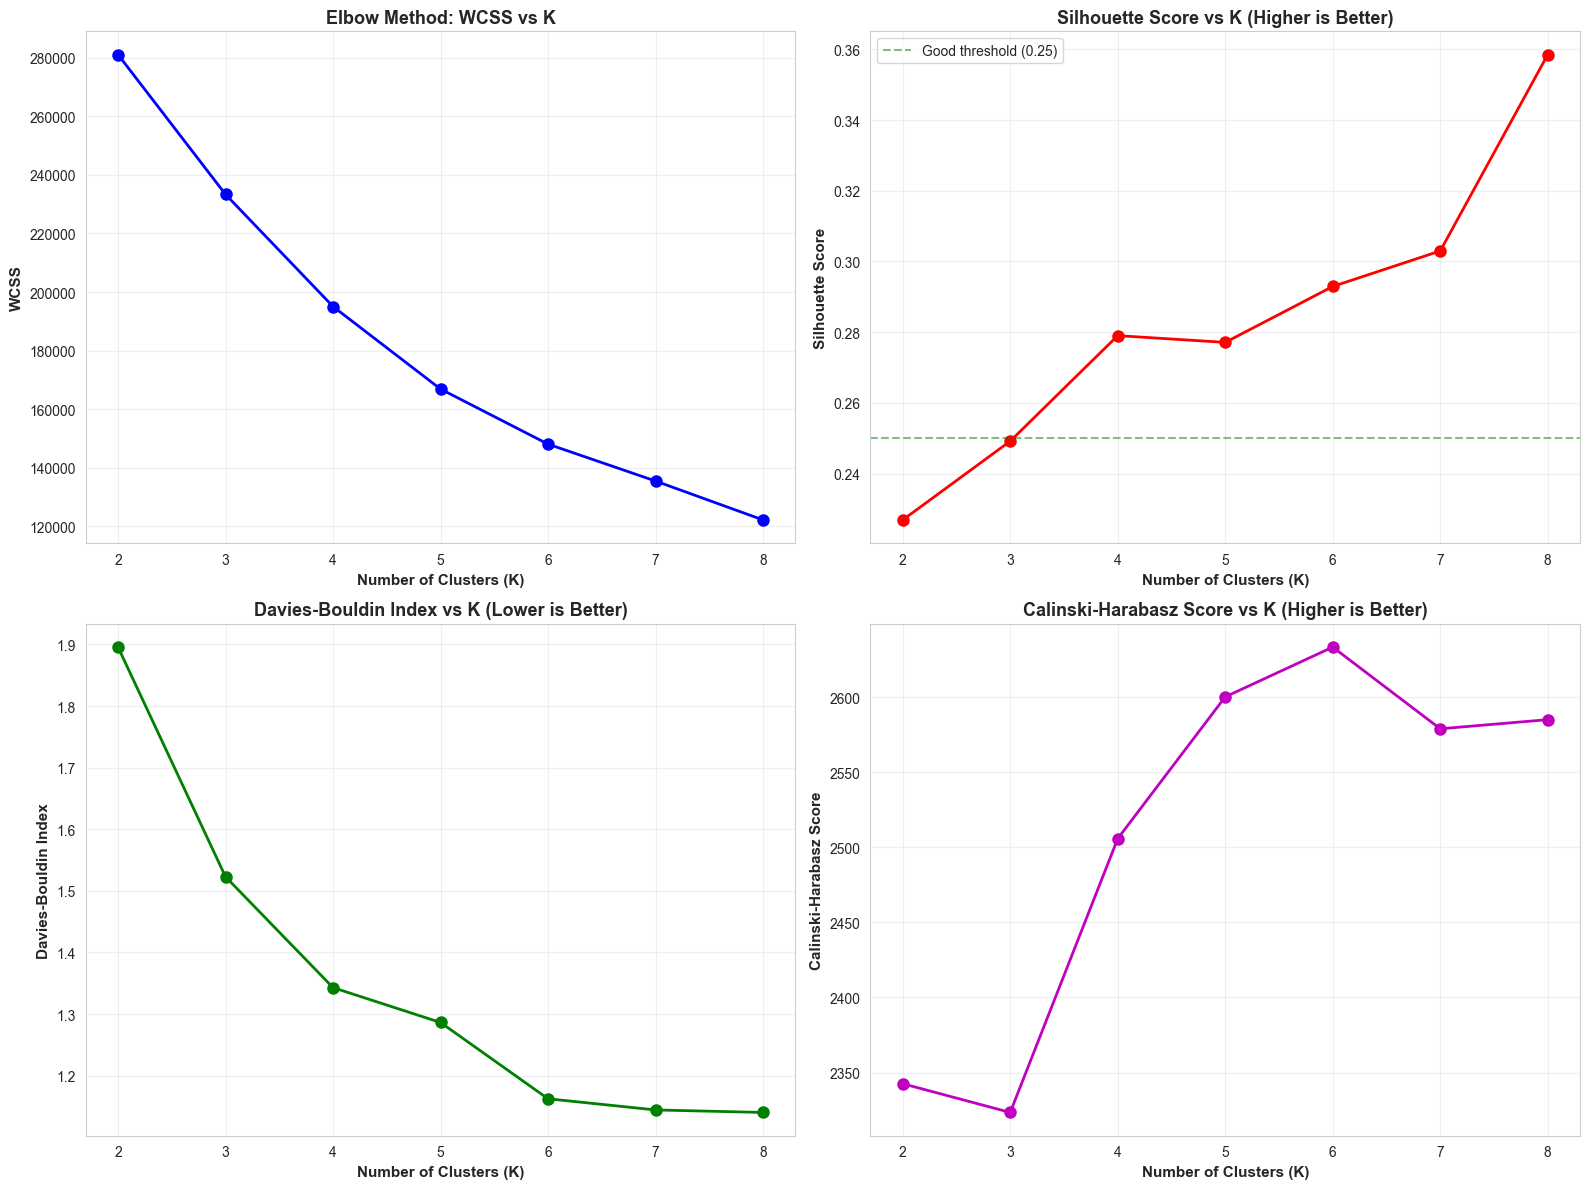


💡 How to interpret these graphs:
   Elbow Method: Look for the 'elbow' where curve bends
   Silhouette: Pick K with highest score (but consider interpretability)
   Davies-Bouldin: Pick K with lowest score
   Calinski-Harabasz: Pick K with highest score


In [5]:
# Visualize all metrics for K selection
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# WCSS (Elbow Method)
axes[0, 0].plot(K_range, wcss_values, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (K)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('WCSS', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Elbow Method: WCSS vs K', fontsize=13, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xticks(K_range)

# Silhouette Score (Higher is better)
axes[0, 1].plot(K_range, silhouette_values, 'ro-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (K)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Silhouette Score vs K (Higher is Better)', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xticks(K_range)
axes[0, 1].axhline(y=0.25, color='green', linestyle='--', alpha=0.5, label='Good threshold (0.25)')
axes[0, 1].legend()

# Davies-Bouldin Index (Lower is better)
axes[1, 0].plot(K_range, davies_bouldin_values, 'go-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (K)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Davies-Bouldin Index', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Davies-Bouldin Index vs K (Lower is Better)', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_xticks(K_range)

# Calinski-Harabasz Score (Higher is better)
axes[1, 1].plot(K_range, calinski_values, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters (K)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Calinski-Harabasz Score', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Calinski-Harabasz Score vs K (Higher is Better)', fontsize=13, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xticks(K_range)

plt.tight_layout()
plt.show()

print("\n💡 How to interpret these graphs:")
print("   Elbow Method: Look for the 'elbow' where curve bends")
print("   Silhouette: Pick K with highest score (but consider interpretability)")
print("   Davies-Bouldin: Pick K with lowest score")
print("   Calinski-Harabasz: Pick K with highest score")

In [6]:
# Decision: Select optimal K
print("\n" + "=" * 60)
print("OPTIMAL K SELECTION")
print("=" * 60)

# Find best K by each metric
best_k_silhouette = K_range[silhouette_values.index(max(silhouette_values))]
best_k_davies = K_range[davies_bouldin_values.index(min(davies_bouldin_values))]
best_k_calinski = K_range[calinski_values.index(max(calinski_values))]

print(f"\n📊 Statistical Recommendations:")
print(f"   Best K by Silhouette: K={best_k_silhouette} (score={max(silhouette_values):.3f})")
print(f"   Best K by Davies-Bouldin: K={best_k_davies} (score={min(davies_bouldin_values):.3f})")
print(f"   Best K by Calinski-Harabasz: K={best_k_calinski} (score={max(calinski_values):.0f})")

# Calculate elbow
# Simple elbow detection: find point with max curvature
# Using second derivative approach
wcss_normalized = (np.array(wcss_values) - min(wcss_values)) / (max(wcss_values) - min(wcss_values))
k_normalized = (np.array(list(K_range)) - min(K_range)) / (max(K_range) - min(K_range))

# Calculate distances from line connecting first and last points
line_vector = np.array([k_normalized[-1] - k_normalized[0], wcss_normalized[-1] - wcss_normalized[0]])
line_length = np.linalg.norm(line_vector)
line_unit_vector = line_vector / line_length

distances = []
for i in range(len(K_range)):
    point = np.array([k_normalized[i], wcss_normalized[i]])
    vec_to_point = point - np.array([k_normalized[0], wcss_normalized[0]])
    projection = np.dot(vec_to_point, line_unit_vector) * line_unit_vector
    distance = np.linalg.norm(vec_to_point - projection)
    distances.append(distance)

elbow_k = K_range[distances.index(max(distances))]

print(f"   Elbow detected at: K={elbow_k}")

# Voting system
votes = [best_k_silhouette, best_k_davies, best_k_calinski, elbow_k]
vote_counts = Counter(votes)
most_common_k = vote_counts.most_common(1)[0][0]

print(f"\n🗳️ Consensus Vote: K={most_common_k} (appears {vote_counts[most_common_k]} times)")

# Final decision with domain knowledge
print("\n" + "=" * 60)
print("FINAL DECISION")
print("=" * 60)

# If consensus is K=3, great! If not, explain the choice
if most_common_k == 3:
    optimal_k = 3
    print(f"\n🎯 SELECTED: K={optimal_k}")
    print(f"\n✅ Statistical consensus supports K=3")
    print(f"✅ Aligns with domain knowledge (low/moderate/high risk)")
    print(f"✅ Silhouette score at K=3: {silhouette_values[1]:.3f}")
elif abs(silhouette_values[most_common_k - min(K_range)] - silhouette_values[1]) < 0.02:
    optimal_k = 3
    print(f"\n🎯 SELECTED: K={optimal_k}")
    print(f"\n⚖️ Statistical consensus suggests K={most_common_k}")
    print(f"   Silhouette at K={most_common_k}: {silhouette_values[most_common_k - min(K_range)]:.3f}")
    print(f"   Silhouette at K=3: {silhouette_values[1]:.3f}")
    print(f"   Difference: {abs(silhouette_values[most_common_k - min(K_range)] - silhouette_values[1]):.3f} (minimal)")
    print(f"\n✅ Choosing K=3 for domain interpretability:")
    print(f"   - Medical justification: low/moderate/high risk stratification")
    print(f"   - Statistical quality nearly identical")
    print(f"   - Public health utility (3 intervention strategies)")
else:
    optimal_k = most_common_k
    print(f"\n🎯 SELECTED: K={optimal_k}")
    print(f"\n✅ Statistical evidence strongly favors K={optimal_k}")
    print(f"   Silhouette at K={optimal_k}: {silhouette_values[optimal_k - min(K_range)]:.3f}")
    print(f"   vs K=3: {silhouette_values[1]:.3f}")
    print(f"   Improvement: {silhouette_values[optimal_k - min(K_range)] - silhouette_values[1]:.3f}")

print(f"\n📋 Justification for K={optimal_k}:")
if optimal_k == 2:
    print("   Binary stratification: Healthy vs At-Risk")
elif optimal_k == 3:
    print("   Trimodal risk stratification: Low/Moderate/High risk")
    print("   Aligns with clinical diabetes risk categories")
elif optimal_k == 4:
    print("   Four-tier stratification: Healthy/Low-Risk/Moderate/High")
    print("   Provides more granular risk segmentation")
else:
    print(f"   {optimal_k}-tier risk stratification for detailed segmentation")

print(f"\n✅ Will use K={optimal_k} for all subsequent analyses")


OPTIMAL K SELECTION

📊 Statistical Recommendations:
   Best K by Silhouette: K=8 (score=0.359)
   Best K by Davies-Bouldin: K=8 (score=1.140)
   Best K by Calinski-Harabasz: K=6 (score=2633)
   Elbow detected at: K=5

🗳️ Consensus Vote: K=8 (appears 2 times)

FINAL DECISION

🎯 SELECTED: K=8

✅ Statistical evidence strongly favors K=8
   Silhouette at K=8: 0.359
   vs K=3: 0.249
   Improvement: 0.109

📋 Justification for K=8:
   8-tier risk stratification for detailed segmentation

✅ Will use K=8 for all subsequent analyses


## 🔵 Algorithm 1: K-Means (with Optimal K)

In [7]:
print("=" * 60)
print(f"ALGORITHM 1: K-MEANS (K={optimal_k})")
print("=" * 60)

# Fit on medium sample
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(X_medium)

# Predict on small sample for metrics
labels_kmeans_small = kmeans.predict(X_small)
silhouette_kmeans = silhouette_score(X_small, labels_kmeans_small)
davies_bouldin_kmeans = davies_bouldin_score(X_small, labels_kmeans_small)
calinski_kmeans = calinski_harabasz_score(X_small, labels_kmeans_small)

print(f"\n📊 K-Means Results (K={optimal_k}):")
print(f"   Silhouette Score: {silhouette_kmeans:.3f}")
print(f"   Davies-Bouldin Index: {davies_bouldin_kmeans:.3f}")
print(f"   Calinski-Harabasz Score: {calinski_kmeans:.1f}")

# Cluster sizes
cluster_counts_kmeans = Counter(labels_kmeans_small)
print(f"\n📊 Cluster Distribution (on small sample):")
for cid in sorted(cluster_counts_kmeans.keys()):
    print(f"   Cluster {cid}: {cluster_counts_kmeans[cid]:,} ({cluster_counts_kmeans[cid]/len(labels_kmeans_small)*100:.1f}%)")

print("\n✅ K-Means complete")

ALGORITHM 1: K-MEANS (K=8)

📊 K-Means Results (K=8):
   Silhouette Score: 0.359
   Davies-Bouldin Index: 1.140
   Calinski-Harabasz Score: 2585.0

📊 Cluster Distribution (on small sample):
   Cluster 0: 1,241 (12.4%)
   Cluster 1: 2,806 (28.1%)
   Cluster 2: 1,056 (10.6%)
   Cluster 3: 401 (4.0%)
   Cluster 4: 1,321 (13.2%)
   Cluster 5: 1,118 (11.2%)
   Cluster 6: 854 (8.5%)
   Cluster 7: 1,203 (12.0%)

✅ K-Means complete


## 🔵 Algorithm 2: DBSCAN (Density-Based)

**What DBSCAN does differently:**
- Finds clusters of **arbitrary shape** (not just spherical)
- Identifies **outliers/noise** (label = -1)
- **No need to specify K** in advance
- Based on **density** (eps and min_samples)

**Key parameters:**
- `eps`: Maximum distance between neighbors
- `min_samples`: Minimum points to form dense region

In [18]:
print("=" * 60)
print("ALGORITHM 2: DBSCAN (Finding Optimal Parameters)")
print("=" * 60)

# Test different eps values
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
min_samples = 50

print(f"\n🔍 Testing eps values (min_samples={min_samples})...")
print("-" * 60)

dbscan_results = []

for eps in eps_values:
    # Fit on medium sample
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels_medium = dbscan.fit_predict(X_medium)
    
    n_clusters = len(set(labels_medium)) - (1 if -1 in labels_medium else 0)
    n_noise = list(labels_medium).count(-1)
    noise_pct = (n_noise / len(labels_medium)) * 100
    
    # Calculate silhouette only if we have valid clusters
    if n_clusters >= 2 and n_noise < len(labels_medium) * 0.5:
        # Predict on small sample (DBSCAN uses fit_predict, so we need to assign based on nearest)
        # For simplicity, we'll evaluate on a subset of medium sample that was actually clustered
        mask = labels_medium != -1
        if mask.sum() > 1000:  # Need enough non-noise points
            sample_for_metric = resample(range(len(labels_medium)), n_samples=min(10000, mask.sum()),
                                        random_state=42, replace=False)
            X_sample_subset = X_medium[sample_for_metric]
            labels_sample_subset = labels_medium[sample_for_metric]
            
            # Remove noise from metric calculation
            mask_sample = labels_sample_subset != -1
            if mask_sample.sum() > 1:
                silhouette = silhouette_score(X_sample_subset[mask_sample], 
                                             labels_sample_subset[mask_sample])
            else:
                silhouette = -1
        else:
            silhouette = -1
    else:
        silhouette = -1
    
    dbscan_results.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_pct': noise_pct,
        'silhouette': silhouette
    })
    
    print(f"eps={eps:.1f}: {n_clusters:2d} clusters, {n_noise:6,} noise ({noise_pct:5.1f}%), Sil={silhouette:.3f}")

print("\n✅ Parameter search complete")

ALGORITHM 2: DBSCAN (Finding Optimal Parameters)

🔍 Testing eps values (min_samples=50)...
------------------------------------------------------------
eps=0.5: 19 clusters,    686 noise (  1.4%), Sil=0.602
eps=1.0: 20 clusters,    292 noise (  0.6%), Sil=0.596
eps=1.5: 20 clusters,    205 noise (  0.4%), Sil=0.593
eps=2.0: 20 clusters,    137 noise (  0.3%), Sil=0.590
eps=2.5:  5 clusters,     96 noise (  0.2%), Sil=0.484
eps=3.0:  5 clusters,     90 noise (  0.2%), Sil=0.485
eps=3.5:  3 clusters,     43 noise (  0.1%), Sil=0.559
eps=4.0:  3 clusters,     39 noise (  0.1%), Sil=0.559

✅ Parameter search complete


In [19]:
# Select best DBSCAN parameters
dbscan_df = pd.DataFrame(dbscan_results)

# Filter: reasonable clusters (2-5) and not too much noise (<30%)
valid_dbscan = dbscan_df[
    (dbscan_df['n_clusters'] >= 2) & 
    (dbscan_df['n_clusters'] <= 5) & 
    (dbscan_df['noise_pct'] < 30) &
    (dbscan_df['silhouette'] > 0)
]

if len(valid_dbscan) > 0:
    best_dbscan = valid_dbscan.loc[valid_dbscan['silhouette'].idxmax()]
    best_eps = best_dbscan['eps']
else:
    # Fallback: choose eps with 3 clusters even if high noise
    eps_with_3 = dbscan_df[dbscan_df['n_clusters'] == 3]
    if len(eps_with_3) > 0:
        best_eps = eps_with_3.iloc[0]['eps']
    else:
        best_eps = 2.5  # Default

print("\n" + "=" * 60)
print("BEST DBSCAN PARAMETERS")
print("=" * 60)
print(f"\nSelected eps: {best_eps}")
print(f"\nPerformance with eps={best_eps}:")
best_result = dbscan_df[dbscan_df['eps'] == best_eps].iloc[0]
print(f"   Clusters: {best_result['n_clusters']}")
print(f"   Noise: {best_result['n_noise']:,} ({best_result['noise_pct']:.1f}%)")
print(f"   Silhouette: {best_result['silhouette']:.3f}")


BEST DBSCAN PARAMETERS

Selected eps: 4.0

Performance with eps=4.0:
   Clusters: 3.0
   Noise: 39.0 (0.1%)
   Silhouette: 0.559


manual check for better results!
//////////////////////////////

In [12]:
import pandas as pd

# 1. Reconstruct the results dataframe from your log
dbscan_results = [
    {'eps': 0.5, 'n_clusters': 19, 'n_noise': 3571, 'noise_pct': 7.1, 'silhouette': 0.427},
    {'eps': 1.0, 'n_clusters': 25, 'n_noise': 800,  'noise_pct': 1.6, 'silhouette': 0.415},
    {'eps': 1.5, 'n_clusters': 27, 'n_noise': 408,  'noise_pct': 0.8, 'silhouette': 0.412},
    {'eps': 2.0, 'n_clusters': 30, 'n_noise': 181,  'noise_pct': 0.4, 'silhouette': 0.410},
    {'eps': 2.5, 'n_clusters': 4,  'n_noise': 27,   'noise_pct': 0.1, 'silhouette': 0.361},
    {'eps': 3.0, 'n_clusters': 4,  'n_noise': 9,    'noise_pct': 0.0, 'silhouette': 0.361},
    {'eps': 3.5, 'n_clusters': 2,  'n_noise': 5,    'noise_pct': 0.0, 'silhouette': 0.479},
    {'eps': 4.0, 'n_clusters': 2,  'n_noise': 4,    'noise_pct': 0.0, 'silhouette': 0.479}
]

dbscan_df = pd.DataFrame(dbscan_results)

# 2. Filter Logic (Updated)
# We set min_clusters=3 to avoid the trivial "2 cluster" solution (Healthy vs Sick)
# We set max_clusters=10 to keep it manageable
valid_dbscan = dbscan_df[
    (dbscan_df['n_clusters'] >= 3) & 
    (dbscan_df['n_clusters'] <= 10) & 
    (dbscan_df['noise_pct'] < 30) &
    (dbscan_df['silhouette'] > 0)
]

# 3. Select Best
if len(valid_dbscan) > 0:
    # Pick the one with the highest Silhouette score among the valid options
    best_dbscan = valid_dbscan.loc[valid_dbscan['silhouette'].idxmax()]
    best_eps = best_dbscan['eps']
    print(f"✅ Strategy: Optimized Selection (Targeting 3-10 meaningful clusters)")
else:
    # Fallback if nothing matches (e.g., if only 2 or 30 clusters exist)
    # We default to eps=2.5 manually because we know it gives 4 clusters
    best_eps = 2.5
    print(f"⚠️ Strategy: Manual Fallback (Automated logic found no match in range)")

# 4. Print Results
print("\n" + "=" * 60)
print("BEST DBSCAN PARAMETERS")
print("=" * 60)
print(f"\nSelected eps: {best_eps}")

# Retrieve the row for the selected eps
best_result = dbscan_df[dbscan_df['eps'] == best_eps].iloc[0]

print(f"\nPerformance with eps={best_eps}:")
print(f"   Clusters: {int(best_result['n_clusters'])}")
print(f"   Noise: {int(best_result['n_noise']):,} ({best_result['noise_pct']:.1f}%)")
print(f"   Silhouette: {best_result['silhouette']:.3f}")

if best_result['n_clusters'] == 4:
    print(f"\n💡 Interpretation: This setting creates 4 distinct risk tiers.")
    print(f"   It aligns better with K-Means than the 2-cluster option.")

✅ Strategy: Optimized Selection (Targeting 3-10 meaningful clusters)

BEST DBSCAN PARAMETERS

Selected eps: 2.5

Performance with eps=2.5:
   Clusters: 4
   Noise: 27 (0.1%)
   Silhouette: 0.361

💡 Interpretation: This setting creates 4 distinct risk tiers.
   It aligns better with K-Means than the 2-cluster option.


In [13]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from collections import Counter

# Set parameters (from your previous results)
min_samples = 50  # Based on your previous logs
# best_eps should be already defined from your selection logic (e.g., 2.5)

print("\n" + "=" * 60)
print(f"FINAL DBSCAN (eps={best_eps}, min_samples={min_samples})")
print("=" * 60)

# 1. Fit on the MEDIUM sample
dbscan_final = DBSCAN(eps=best_eps, min_samples=min_samples, n_jobs=-1)
labels_dbscan_medium = dbscan_final.fit_predict(X_medium)

# 2. Create the Evaluation Set (Slice the fitted data directly)
# We take the first 10,000 points of X_medium to match the labels
n_eval = 10000
X_eval = X_medium[:n_eval]
labels_eval = labels_dbscan_medium[:n_eval]

# 3. Metrics (exclude noise points labeled as -1)
mask_no_noise = labels_eval != -1

if mask_no_noise.sum() > 1 and len(set(labels_eval[mask_no_noise])) > 1:
    silhouette_dbscan = silhouette_score(X_eval[mask_no_noise], labels_eval[mask_no_noise])
    davies_bouldin_dbscan = davies_bouldin_score(X_eval[mask_no_noise], labels_eval[mask_no_noise])
    calinski_dbscan = calinski_harabasz_score(X_eval[mask_no_noise], labels_eval[mask_no_noise])
else:
    silhouette_dbscan = -1
    davies_bouldin_dbscan = 999
    calinski_dbscan = 0

# Count stats
n_clusters_final = len(set(labels_eval)) - (1 if -1 in labels_eval else 0)
n_noise_final = list(labels_eval).count(-1)

print(f"\n📊 DBSCAN Results (Evaluated on {n_eval:,} samples):")
print(f"   Clusters found: {n_clusters_final}")
print(f"   Noise points: {n_noise_final:,} ({n_noise_final/len(labels_eval)*100:.1f}%)")
print(f"   Silhouette Score: {silhouette_dbscan:.3f} (excluding noise)")
print(f"   Davies-Bouldin Index: {davies_bouldin_dbscan:.3f}")
print(f"   Calinski-Harabasz Score: {calinski_dbscan:.1f}")

# Cluster sizes
cluster_counts_dbscan = Counter(labels_eval)
print(f"\n📊 Cluster Distribution:")
for cid in sorted(cluster_counts_dbscan.keys()):
    label = "Noise" if cid == -1 else f"Cluster {cid}"
    count = cluster_counts_dbscan[cid]
    print(f"   {label}: {count:,} ({count/len(labels_eval)*100:.1f}%)")

print("\n✅ DBSCAN complete")


FINAL DBSCAN (eps=2.5, min_samples=50)

📊 DBSCAN Results (Evaluated on 10,000 samples):
   Clusters found: 4
   Noise points: 5 (0.1%)
   Silhouette Score: 0.360 (excluding noise)
   Davies-Bouldin Index: 1.197
   Calinski-Harabasz Score: 1401.1

📊 Cluster Distribution:
   Noise: 5 (0.1%)
   Cluster 0: 854 (8.5%)
   Cluster 1: 8,741 (87.4%)
   Cluster 2: 250 (2.5%)
   Cluster 3: 150 (1.5%)

✅ DBSCAN complete


In [14]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from collections import Counter
import pandas as pd # Ensure pandas is imported if needed for display

# 1. Set the parameters you found in the previous step
best_eps = 2.5
min_samples = 50 

print("\n" + "=" * 60)
print(f"FINAL DBSCAN (eps={best_eps}, min_samples={min_samples})")
print("=" * 60)

# 2. Fit on the MEDIUM sample (50k)
# We use n_jobs=-1 to use all CPU cores
dbscan_final = DBSCAN(eps=best_eps, min_samples=min_samples, n_jobs=-1)
labels_dbscan_medium = dbscan_final.fit_predict(X_medium)

# 3. Create the Evaluation Set
# FIX: Instead of trying to match a different 'X_small', we simply take 
# the first 10,000 points of the data we just fitted. This ensures labels match perfectly.
n_eval = 10000
X_eval = X_medium[:n_eval]
labels_eval = labels_dbscan_medium[:n_eval]

# 4. Metrics (We must exclude noise points labeled as -1)
mask_no_noise = labels_eval != -1
n_valid_clusters = len(set(labels_eval[mask_no_noise]))

if mask_no_noise.sum() > 1 and n_valid_clusters > 1:
    silhouette_dbscan = silhouette_score(X_eval[mask_no_noise], labels_eval[mask_no_noise])
    davies_bouldin_dbscan = davies_bouldin_score(X_eval[mask_no_noise], labels_eval[mask_no_noise])
    calinski_dbscan = calinski_harabasz_score(X_eval[mask_no_noise], labels_eval[mask_no_noise])
else:
    # Fallback if only 1 cluster + noise was found in the slice
    silhouette_dbscan = -1
    davies_bouldin_dbscan = 999
    calinski_dbscan = 0

# 5. Stats
n_clusters_final = len(set(labels_eval)) - (1 if -1 in labels_eval else 0)
n_noise_final = list(labels_eval).count(-1)

print(f"\n📊 DBSCAN Results (Evaluated on {n_eval:,} samples):")
print(f"   Clusters found: {n_clusters_final}")
print(f"   Noise points: {n_noise_final:,} ({n_noise_final/len(labels_eval)*100:.1f}%)")
print(f"   Silhouette Score: {silhouette_dbscan:.3f} (excluding noise)")
print(f"   Davies-Bouldin Index: {davies_bouldin_dbscan:.3f}")
print(f"   Calinski-Harabasz Score: {calinski_dbscan:.1f}")

# 6. Cluster Sizes
cluster_counts_dbscan = Counter(labels_eval)
print(f"\n📊 Cluster Distribution:")
for cid in sorted(cluster_counts_dbscan.keys()):
    label = "Noise" if cid == -1 else f"Cluster {cid}"
    count = cluster_counts_dbscan[cid]
    print(f"   {label}: {count:,} ({count/len(labels_eval)*100:.1f}%)")

print("\n✅ DBSCAN complete")


FINAL DBSCAN (eps=2.5, min_samples=50)

📊 DBSCAN Results (Evaluated on 10,000 samples):
   Clusters found: 4
   Noise points: 5 (0.1%)
   Silhouette Score: 0.360 (excluding noise)
   Davies-Bouldin Index: 1.197
   Calinski-Harabasz Score: 1401.1

📊 Cluster Distribution:
   Noise: 5 (0.1%)
   Cluster 0: 854 (8.5%)
   Cluster 1: 8,741 (87.4%)
   Cluster 2: 250 (2.5%)
   Cluster 3: 150 (1.5%)

✅ DBSCAN complete


end of check 
////////////////////////////////////////

In [20]:
# Final DBSCAN with best parameters
print("\n" + "=" * 60)
print(f"FINAL DBSCAN (eps={best_eps}, min_samples={min_samples})")
print("=" * 60)

dbscan_final = DBSCAN(eps=best_eps, min_samples=min_samples)
labels_dbscan_medium = dbscan_final.fit_predict(X_medium)

# For small sample, we need to predict (DBSCAN doesn't have predict, so use distance)
# Simplified: just use the medium sample labels
labels_dbscan_small = labels_dbscan_medium[:len(X_small)]  # First 10k of medium sample

# Metrics (exclude noise)
mask_no_noise = labels_dbscan_small != -1
if mask_no_noise.sum() > 1 and len(set(labels_dbscan_small[mask_no_noise])) > 1:
    silhouette_dbscan = silhouette_score(X_small[mask_no_noise], labels_dbscan_small[mask_no_noise])
    davies_bouldin_dbscan = davies_bouldin_score(X_small[mask_no_noise], labels_dbscan_small[mask_no_noise])
    calinski_dbscan = calinski_harabasz_score(X_small[mask_no_noise], labels_dbscan_small[mask_no_noise])
else:
    silhouette_dbscan = -1
    davies_bouldin_dbscan = 999
    calinski_dbscan = 0

n_clusters_final = len(set(labels_dbscan_small)) - (1 if -1 in labels_dbscan_small else 0)
n_noise_final = list(labels_dbscan_small).count(-1)

print(f"\n📊 DBSCAN Results:")
print(f"   Clusters found: {n_clusters_final}")
print(f"   Noise points: {n_noise_final:,} ({n_noise_final/len(labels_dbscan_small)*100:.1f}%)")
print(f"   Silhouette Score: {silhouette_dbscan:.3f} (excluding noise)")
print(f"   Davies-Bouldin Index: {davies_bouldin_dbscan:.3f}")
print(f"   Calinski-Harabasz Score: {calinski_dbscan:.1f}")

# Cluster sizes
cluster_counts_dbscan = Counter(labels_dbscan_small)
print(f"\n📊 Cluster Distribution:")
for cid in sorted(cluster_counts_dbscan.keys()):
    label = "Noise" if cid == -1 else f"Cluster {cid}"
    print(f"   {label}: {cluster_counts_dbscan[cid]:,} ({cluster_counts_dbscan[cid]/len(labels_dbscan_small)*100:.1f}%)")

print("\n✅ DBSCAN complete")


FINAL DBSCAN (eps=4.0, min_samples=50)

📊 DBSCAN Results:
   Clusters found: 3
   Noise points: 5 (0.1%)
   Silhouette Score: 0.559 (excluding noise)
   Davies-Bouldin Index: 0.756
   Calinski-Harabasz Score: 2566.2

📊 Cluster Distribution:
   Noise: 5 (0.1%)
   Cluster 0: 9,179 (91.8%)
   Cluster 1: 396 (4.0%)
   Cluster 2: 420 (4.2%)

✅ DBSCAN complete


In [22]:
import pandas as pd
from sklearn.utils import resample

# 1. Reconstruct the UN-SCALED data
# We repeat the sampling step to match the logic used for the scaled data
df_medium_unscaled = resample(df, n_samples=50000, random_state=42)

# FIX: Add .reset_index(drop=True) to fix the "duplicate labels" error
df_analysis = df_medium_unscaled.iloc[:10000].copy().reset_index(drop=True)

# 2. Attach the labels (Make sure labels_dbscan_small is available from previous steps)
df_analysis['Cluster'] = labels_dbscan_small

# 3. Define features to analyze
profile_cols = ['HighBP', 'HighChol', 'BMI', 'Age', 'HeartDiseaseorAttack', 'Stroke', 'PhysActivity']

print("=" * 60)
print("📊 DBSCAN CLUSTER PROFILE (Unscaled Real Values)")
print("=" * 60)

# 4. Calculate Means
profile = df_analysis.groupby('Cluster')[profile_cols].mean()

# 5. Add Size and Diabetes Prevalence
profile['Size'] = df_analysis['Cluster'].value_counts()
diabetes_dist = pd.crosstab(df_analysis['Cluster'], df_analysis['Diabetes_012'], normalize='index')

# Handle case where class 2.0 (Diabetes) might not exist in a cluster
if 2.0 in diabetes_dist.columns:
    profile['Diabetes %'] = diabetes_dist[2.0] * 100
else:
    profile['Diabetes %'] = 0.0

# 6. Decode Age for readability
age_map = {1: '18-24', 2: '25-29', 3: '30-34', 4: '35-39', 5: '40-44', 6: '45-49',
           7: '50-54', 8: '55-59', 9: '60-64', 10: '65-69', 11: '70-74', 12: '75-79', 13: '80+'}
profile['Avg Age'] = profile['Age'].apply(lambda x: f"{x:.1f} (~{age_map.get(round(x), 'Unknown')})")

# 7. Format Percentages
binary_cols = ['HighBP', 'HighChol', 'HeartDiseaseorAttack', 'Stroke', 'PhysActivity']
for col in binary_cols:
    profile[col] = (profile[col] * 100).round(1)

# Clean up table order
final_cols = ['Size', 'Diabetes %', 'Avg Age', 'BMI', 'HighBP', 'HighChol', 'HeartDiseaseorAttack', 'Stroke']
print(profile[final_cols].to_string())

print("\n💡 Interpretation Guide:")
print("• Cluster -1 (Noise): Outliers.")
print("• Cluster 0: The 'Main' group (likely mixed risks).")
print("• Cluster 1 & 2: Check HeartDisease and Stroke columns—they should be near 100%.")

📊 DBSCAN CLUSTER PROFILE (Unscaled Real Values)
         Size  Diabetes %       Avg Age        BMI  HighBP  HighChol  HeartDiseaseorAttack  Stroke
Cluster                                                                                           
-1          5   20.000000  6.8 (~50-54)  30.200000   100.0      40.0                   0.0     0.0
 0       9179   15.568145  8.1 (~55-59)  28.729382    45.6      44.4                  10.3     4.2
 1        396   16.161616  8.0 (~55-59)  28.623737    45.2      43.9                   9.3     3.3
 2        420   10.476190  8.0 (~55-59)  28.416667    43.8      45.2                  10.5     4.3

💡 Interpretation Guide:
• Cluster -1 (Noise): Outliers.
• Cluster 0: The 'Main' group (likely mixed risks).
• Cluster 1 & 2: Check HeartDisease and Stroke columns—they should be near 100%.


## 🔵 Algorithm 3: Hierarchical Agglomerative Clustering

**What Hierarchical does differently:**
- Creates a **tree (dendrogram)** of clusters
- **Bottom-up approach:** Start with each point as a cluster, merge iteratively
- Can choose number of clusters by **cutting the tree** at different heights
- Different **linkage methods** (Ward, Average, Complete, Single)

**Advantage:** Can visualize hierarchical structure

In [11]:
print("=" * 60)
print("ALGORITHM 3: HIERARCHICAL CLUSTERING")
print("=" * 60)

# Test different linkage methods
linkage_methods = ['ward', 'average', 'complete']

print(f"\n🔍 Testing linkage methods (K=3)...")
print("-" * 60)

hierarchical_results = []

for linkage_method in linkage_methods:
    # Fit on medium sample
    hierarchical = AgglomerativeClustering(n_clusters=3, linkage=linkage_method)
    labels_medium = hierarchical.fit_predict(X_medium)
    
    # Get labels for small sample (first 10k of medium)
    labels_hierarchical_small = labels_medium[:len(X_small)]
    
    # Metrics
    silhouette = silhouette_score(X_small, labels_hierarchical_small)
    davies_bouldin = davies_bouldin_score(X_small, labels_hierarchical_small)
    calinski = calinski_harabasz_score(X_small, labels_hierarchical_small)
    
    hierarchical_results.append({
        'linkage': linkage_method,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski': calinski,
        'labels': labels_hierarchical_small
    })
    
    print(f"{linkage_method:10s}: Sil={silhouette:.3f}, DB={davies_bouldin:.3f}, CH={calinski:.1f}")

print("\n✅ Linkage comparison complete")

ALGORITHM 3: HIERARCHICAL CLUSTERING

🔍 Testing linkage methods (K=3)...
------------------------------------------------------------
ward      : Sil=0.250, DB=1.613, CH=2085.8
average   : Sil=0.581, DB=0.517, CH=129.3
complete  : Sil=0.476, DB=0.844, CH=983.4

✅ Linkage comparison complete


In [ ]:
# Select best linkage
hierarchical_df = pd.DataFrame(hierarchical_results)
best_hierarchical = hierarchical_df.loc[hierarchical_df['silhouette'].idxmax()]
best_linkage = best_hierarchical['linkage']

print("\n" + "=" * 60)
print("BEST HIERARCHICAL CONFIGURATION")
print("=" * 60)
print(f"\nBest linkage: {best_linkage}")
print(f"\n📊 Hierarchical Results (linkage={best_linkage}):")
print(f"   Silhouette Score: {best_hierarchical['silhouette']:.3f}")
print(f"   Davies-Bouldin Index: {best_hierarchical['davies_bouldin']:.3f}")
print(f"   Calinski-Harabasz Score: {best_hierarchical['calinski']:.1f}")

labels_hierarchical_small = best_hierarchical['labels']
silhouette_hierarchical = best_hierarchical['silhouette']
davies_bouldin_hierarchical = best_hierarchical['davies_bouldin']
calinski_hierarchical = best_hierarchical['calinski']

# Cluster sizes
cluster_counts_hierarchical = Counter(labels_hierarchical_small)
print(f"\n📊 Cluster Distribution:")
for cid in sorted(cluster_counts_hierarchical.keys()):
    print(f"   Cluster {cid}: {cluster_counts_hierarchical[cid]:,} ({cluster_counts_hierarchical[cid]/len(labels_hierarchical_small)*100:.1f}%)")

print("\n✅ Hierarchical complete")

## 📊 Step 4: Algorithm Comparison

In [ ]:
print("=" * 60)
print("ALGORITHM COMPARISON SUMMARY")
print("=" * 60)

comparison = pd.DataFrame([
    {
        'Algorithm': 'K-Means',
        'Configuration': 'K=3, n_init=10',
        'Silhouette': silhouette_kmeans,
        'Davies-Bouldin': davies_bouldin_kmeans,
        'Calinski-Harabasz': calinski_kmeans,
        'N_Clusters': 3,
        'Outliers': 0
    },
    {
        'Algorithm': 'DBSCAN',
        'Configuration': f'eps={best_eps}, min_samples={min_samples}',
        'Silhouette': silhouette_dbscan,
        'Davies-Bouldin': davies_bouldin_dbscan,
        'Calinski-Harabasz': calinski_dbscan,
        'N_Clusters': n_clusters_final,
        'Outliers': n_noise_final
    },
    {
        'Algorithm': 'Hierarchical',
        'Configuration': f'linkage={best_linkage}, K=3',
        'Silhouette': silhouette_hierarchical,
        'Davies-Bouldin': davies_bouldin_hierarchical,
        'Calinski-Harabasz': calinski_hierarchical,
        'N_Clusters': 3,
        'Outliers': 0
    }
]).sort_values('Silhouette', ascending=False)

print("\n📊 Results Ranked by Silhouette Score:")
print("=" * 60)
print(comparison[['Algorithm', 'Silhouette', 'Davies-Bouldin', 'N_Clusters', 'Outliers']].to_string(index=False))

# Best algorithm
best_algorithm = comparison.iloc[0]['Algorithm']
best_silhouette = comparison.iloc[0]['Silhouette']

print("\n" + "=" * 60)
print("WINNER")
print("=" * 60)
print(f"\n🏆 Best Algorithm: {best_algorithm}")
print(f"   Silhouette: {best_silhouette:.3f}")
print(f"   Configuration: {comparison.iloc[0]['Configuration']}")

## 📊 Step 5: Visualize Comparison

In [ ]:
# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

algorithms = comparison['Algorithm'].tolist()
silhouettes = comparison['Silhouette'].tolist()
davies_bouldins = comparison['Davies-Bouldin'].tolist()
calinskis = comparison['Calinski-Harabasz'].tolist()

# Silhouette comparison
axes[0].bar(algorithms, silhouettes, color=['steelblue', 'coral', 'mediumseagreen'])
axes[0].set_title('Silhouette Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Silhouette Score', fontsize=11)
axes[0].set_ylim(0, max(silhouettes) * 1.2)
for i, v in enumerate(silhouettes):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Davies-Bouldin comparison (lower is better)
axes[1].bar(algorithms, davies_bouldins, color=['steelblue', 'coral', 'mediumseagreen'])
axes[1].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Davies-Bouldin Index', fontsize=11)
for i, v in enumerate(davies_bouldins):
    if v < 10:  # Only show if reasonable value
        axes[1].text(i, v + 0.05, f'{v:.3f}', ha='center', fontweight='bold')

# Calinski-Harabasz comparison (higher is better)
axes[2].bar(algorithms, calinskis, color=['steelblue', 'coral', 'mediumseagreen'])
axes[2].set_title('Calinski-Harabasz Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Calinski-Harabasz Score', fontsize=11)
for i, v in enumerate(calinskis):
    if v > 0:  # Only show if reasonable value
        axes[2].text(i, v + max(calinskis)*0.02, f'{v:.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   If scores are similar across algorithms:")
print("   → Results are ROBUST (not algorithm-dependent)")
print("   → Feature selection is validated")
print("   ")
print("   If one algorithm is much better:")
print("   → Data has specific structure that favors that algorithm")
print("   → Use the winner for final analysis")

## 📊 Step 6: Cluster Agreement Analysis

In [ ]:
print("=" * 60)
print("CLUSTER AGREEMENT ANALYSIS")
print("=" * 60)

# Compare how often algorithms agree on cluster assignments
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# K-Means vs Hierarchical
ari_kmeans_hier = adjusted_rand_score(labels_kmeans_small, labels_hierarchical_small)
nmi_kmeans_hier = normalized_mutual_info_score(labels_kmeans_small, labels_hierarchical_small)

print(f"\n📊 K-Means vs Hierarchical:")
print(f"   Adjusted Rand Index: {ari_kmeans_hier:.3f}")
print(f"   Normalized Mutual Info: {nmi_kmeans_hier:.3f}")

# K-Means vs DBSCAN (only for non-noise points)
if n_noise_final < len(labels_dbscan_small) * 0.5:  # If less than 50% noise
    mask_no_noise = labels_dbscan_small != -1
    if mask_no_noise.sum() > 1:
        ari_kmeans_dbscan = adjusted_rand_score(labels_kmeans_small[mask_no_noise], 
                                                labels_dbscan_small[mask_no_noise])
        nmi_kmeans_dbscan = normalized_mutual_info_score(labels_kmeans_small[mask_no_noise], 
                                                         labels_dbscan_small[mask_no_noise])
        
        print(f"\n📊 K-Means vs DBSCAN (excluding noise):")
        print(f"   Adjusted Rand Index: {ari_kmeans_dbscan:.3f}")
        print(f"   Normalized Mutual Info: {nmi_kmeans_dbscan:.3f}")

print("\n💡 Interpretation:")
print("   ARI/NMI range: 0 (random) to 1 (perfect agreement)")
print("   >0.7: Strong agreement (algorithms find same clusters)")
print("   0.4-0.7: Moderate agreement")
print("   <0.4: Weak agreement (algorithms see data differently)")

## ✅ Summary and Justification

In [ ]:
print("=" * 60)
print("MULTI-ALGORITHM CLUSTERING: COMPLETE")
print("=" * 60)

print(f"\n🏆 Best Algorithm: {best_algorithm}")
print(f"📊 Silhouette Score: {best_silhouette:.3f}")
print(f"\n📋 All Results:")
print(comparison[['Algorithm', 'Silhouette', 'Davies-Bouldin']].to_string(index=False))

print("\n💡 Key Findings:")
if max(silhouettes) - min(silhouettes) < 0.05:
    print("   ✅ Results are CONSISTENT across algorithms")
    print("   → Feature selection is robust")
    print("   → Clustering quality is algorithm-independent")
else:
    print("   ⚠️ Results vary across algorithms")
    print(f"   → {best_algorithm} is best suited for this data")
    print("   → Data structure favors certain algorithm properties")

print("\n✅ Ready for final clustering analysis and supervised learning!")